In [48]:
#import required Python libraries
import pandas as pd
from pandas import merge
import numpy as np

#!conda install -c conda-forge beautifulsoup4 --yes 

#from bs4 import BeautifulSoup
from urllib.request import urlopen

#!pip install lxml

import json 
from pandas.io.json import json_normalize 

!pip install geopy
#!conda install -c conda-forge geopy --yes 
from geopy.distance import distance
from geopy.geocoders import Nominatim 

import requests 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium 

print("Libraries imported.")

Libraries imported.


<h1>PROJECT OVERVIEW</h1>
In June 2020 mayoral elections took place in Paris, France. The winning candidate wants to make Paris a city where anyone living in the city can reach key services and amenities within a 15 minutes walk or bike ride from home. Achieving this vision would yield several benefits, among which: improving quality of life, reconnecting people with their neighborhoods and improving air quality by reducing drastically the need to drive.
<br><br>
Our goal for this project will be to answer the following questions pertaining to easy access to medical services:
<ul>
<li>What is the overall current state of readiness of the city and the districts within it in respect to this "15 minutes" goal?</li> 
<li>Can we identify neighborhoods that share similar characteristics and group them together so that specific dedicated action plans can be defined to enable the "15 minutes" vision in these neighborhoods?</li>
</ul>


<h2>1. DATASETS RETRIEVAL</h2>

<h4>
We will use 2 datasets for this project:
<ul>
    <li>Apartments (residences) in a few Parisian districts. Source = open data library provided by the City of Paris.</li>
    <li>Medical services of various categories (e.g Doctor's office, Hospital, Medical Center...). Source = Foursquare Venues dataset </li>
</ul>
</h4>

<b>NOTE:</b> Initially I wanted to use a list of residences provided by Foursquare but during the development of this project I could not retrieve correct lists despite providing the right venue category IDs. This could be related to some data privacy restrictions in certain countries. As an alternative I decided to use a list of Social Residences with geographical coordinates provided by the City of Paris on their open data website.


<h3>First we retrieve residences data from the City of Paris.</h3>

<h4><b>IMPORTANT:</b> Because of the limited number of calls that can be made via the Foursquare API using free services we will restrict the number of residences used for this project. We will only include residences from 3 districts: 17th, 18th and 19th.</h4>

In [49]:
# Code to retrieve the list of social residences provided by the City of Paris on their open data website. 
# The files are available in JSON format.

def getResidences():     
    url='https://opendata.paris.fr/api/records/1.0/search/?dataset=logements-sociaux-finances-a-paris&rows=5000&facet=annee&facet=bs&facet=mode_real&facet=arrdt&facet=nature_programme'
    results = requests.get(url).json()['records']

    if len(results) == 0: 
        return()
    
    residences_list=[]

    # We will retrieve geographical coordinates but also the postal code from which we can derive the district number. 
    # e.g a residence in the 17th district has a postal code ending with the number 17. 
    for r in results:
        residences_list.append([r['recordid'], r['fields']['code_postal'], r['fields']['geo_point_2d'][0], r['fields']['geo_point_2d'][1]])
        
    # Build residences dataframe by processing each item from the list created using the JSON data
    output_df = pd.DataFrame([item for item in residences_list])
    output_df.columns = ['Residence ID', 'Postal Code', 'Residence Lat', 'Residence Long'] 
    
    return(output_df)




In [50]:
# This will be our raw residences dataframe for the rest of the project.
residences_df_raw = getResidences()

print('Shape of raw residences dataframe: ', residences_df_raw.shape)

Shape of raw residences dataframe:  (3392, 4)


In [51]:
# Create our working residences dataframe restricted to the 3 districts selected for this project.
residences_df = residences_df_raw[(residences_df_raw['Postal Code'] == 75017) | (residences_df_raw['Postal Code'] == 75018) | (residences_df_raw['Postal Code'] == 75019)]

print('Shape of residences dataframe only including the 17th, 18th and 19th districts: ', residences_df.shape)

Shape of residences dataframe only including the 17th, 18th and 19th districts:  (918, 4)


In [52]:
# Let's check some records to confirm that the dataframe contains expected data
print('First few records of this dataframe:')
residences_df.head()

First few records of this dataframe:


Residence ID  Postal Code  Residence Lat  \
11  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
13  60adda8cbfaf3d675ff74e0df7f30634a32729a5        75018      48.896724   
17  e99900654a9dd5c8f284b727891dc3376254edfb        75019      48.875744   
18  e491fc803976f1fd7069c4e66e6d18e43616146c        75019      48.892673   
25  d48ddcb59d1c6756b54f6b4c1874dfe9bcf6334c        75017      48.885754   

    Residence Long  
11        2.379723  
13        2.358741  
17        2.399541  
18        2.385416  
25        2.289612

<h3>Now we retrieve Medical Services using the Foursquare API.</h3>

<h4>We identify relevant venue category IDs using the Foursquare API documentation available online.</h4>

<h4>This portion of code took a few attempts to finalize because the Foursquare data seem to have a few gaps. For instance some venues don't have a postal code or a category ID. This is why a few conditional clauses are included in the code below to address some data exceptions that were causing the creation of an output dataframe to fail initially.</h4>

In [53]:
# Services retrieval from Foursquare
# Criteria: Services in Paris, for the following category IDs: 4bf58dd8d48988d177941735, 4bf58dd8d48988d178941735, 4bf58dd8d48988d196941735

CLIENT_ID = 'DYWALHDQR14F3DOLF15S330FTVDXBHEXIJNZ5DS2DT1U51HA' 
CLIENT_SECRET = 'HBKWUMJP3R33ZWCMZJ2L23U5ELUH21EXCCIZLBH1VIYNPV5J' 
VERSION = '20180605'

# Create a function that retrieves all venues in a list of categories, for a given city in a given country
def getVenues(lat, long, venue_categories, radius, limit):
    
    coordinates = lat + ',' + long
    
    venues_list=[]
    
    # we use explore instead of search for the Foursquare API call as it returns more records 
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            coordinates,
            venue_categories,
            radius,
            limit
            ) 
    
    # make the GET request
    results_tmp = requests.get(url).json()['response']
    
    # if no results available return nothing
    if len(results_tmp) == 0: 
        return([])
 
    #if 'groups' in results_tmp.keys():
    if 'groups' in results_tmp.keys() and len(results_tmp['groups'][0]['items']) > 0:
        results = results_tmp['groups'][0]['items']
    else: 
        return([])
    
    # loop through results set to build a list of venues with relevant information for our analysis. 
    # WARNING: some venues appear to be missing the postal code information and/or category information, 
    # hence the verifications below:
 
    for v in results:
        #print(v)
        if 'postalCode' in v['venue']['location'].keys():
            if 'categories' in v['venue'].keys() and len(v['venue']['categories']) > 0:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                v['venue']['location']['lng'], v['venue']['location']['postalCode'], 
                    v['venue']['categories'][0]['name'], v['venue']['categories'][0]['id']])
            else:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                v['venue']['location']['lng'], v['venue']['location']['postalCode'], 'n/a', 'n/a'])
        
        elif 'categories' in v['venue'].keys() and len(v['venue']['categories']) > 0:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                v['venue']['location']['lng'], 'n/a', 
                    v['venue']['categories'][0]['name'], v['venue']['categories'][0]['id']])
        else:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                    v['venue']['location']['lng'], 'n/a', 'n/a', 'n/a'])

    # Transform the list of results into a dataframe to be returned by the function.
    nearby_venues = pd.DataFrame([item for item in venues_list])
    nearby_venues.columns = [
        'Venue ID',
        'Venue Name', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Postal Code',
        'Venue Category',
        'Venue Category ID']
    
    return(nearby_venues)


<h4>We will be looking for medical services in a 500 meters radius of the residences included in our project. Therefore, we need to extract all the geographical coordinates of the residences and remove duplicates.</h4>
<h4>Once this is done we will remove duplicate medical services and clean up our dataframes.</h4>

In [54]:
residences_coord = residences_df[['Residence Lat', 'Residence Long']]
print('Residences coordinates dataframe shape:', residences_coord.shape)

residences_coord2 = residences_coord.drop_duplicates(inplace = False)
print('Residences coordinates dataframe shape after removing duplicates:', residences_coord2.shape)

Residences coordinates dataframe shape: (918, 2)
Residences coordinates dataframe shape after removing duplicates: (829, 2)


In [55]:
# Medical venue category IDs to be used for the Foursquare API call using the function created above:
med_venue_categories = '4bf58dd8d48988d177941735,4bf58dd8d48988d178941735,4bf58dd8d48988d196941735'

med_services = pd.DataFrame()

print('Start retrieving all medical services in 500m radius of residences coordinates.')

for index, row in residences_coord2.iterrows():
    med_services = med_services.append(getVenues(str(row['Residence Lat']), str(row['Residence Long']), med_venue_categories, 500, 1000))
    
print('Medical services identified for all coordinates in residences dataframe.')

Start retrieving all medical services in 500m radius of residences coordinates.
Medical services identified for all coordinates in residences dataframe.


In [56]:
print('Shape of Medical Services dataframe retrieved: ', med_services.shape)

Shape of Medical Services dataframe retrieved:  (652, 7)


In [57]:
# Let's remove duplicate medical services returned by the Foursquare API and check the shape of our clean medical services dataframe 
med_services_clean = med_services.drop_duplicates()
print('Shape of Medical Services dataframe after removing duplicates: ', med_services_clean.shape)

Shape of Medical Services dataframe after removing duplicates:  (179, 7)


In [58]:
# We reset the index to finalize the Medical Services dataframe that we will use going forward.
med_services_clean.reset_index(inplace = True)

<h4><b>NOTE:</b> We are going to remove a few categories of medical services we are not interested in for this project. 
First let's see which categories are available in our dataset.</h4>

In [59]:
print('Unique categories of medical services in our medical services dataset: ', med_services_clean['Venue Category'].unique())

Unique categories of medical services in our medical services dataset:  ["Doctor's Office" "Dentist's Office" 'Hospital' 'Medical Center'
 'Daycare' 'Optical Shop' 'Miscellaneous Shop']


<h4><b>NOTE:</b>To limit the volume of data that will be used we decide to exclude: Daycare, Laboratory and Miscellaneous Shop. This will help with working around some memory issues impacting the display of maps further down in this project.</h4>

In [60]:
# Retrieve indices of records where the Venue Category is one of the Medical Services we want to exclude from our project.
med_services_clean.drop(med_services_clean[(med_services_clean['Venue Category'] == 'Miscellaneous Shop') 
                            | (med_services_clean['Venue Category'] == 'Daycare') 
                            | (med_services_clean['Venue Category'] == 'Laboratory')].index, inplace = True)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [61]:
print('We confirm this deletion by checking the remaining unique categories of medical services in our medical services dataset: ', med_services_clean['Venue Category'].unique())

We confirm this deletion by checking the remaining unique categories of medical services in our medical services dataset:  ["Doctor's Office" "Dentist's Office" 'Hospital' 'Medical Center'
 'Optical Shop']


In [62]:
print('We check the first few records of our Medical Services dataset:')
med_services_clean.head()

We check the first few records of our Medical Services dataset:


index                  Venue ID  \
0      0  5bf83feb1c0b34002c520e51   
1      1  584ecc5fd8f3e90bf9170d8c   
2      2  593c0626fc9e940adf2bd441   
3      3  4e00c89fc65b896d116b6ca1   
4      4  5e70f46734c6bd00087aa3d6   

                                          Venue Name  Venue Latitude  \
0                                 Dr Maxime Reichman       48.899106   
1                          Centre Dentaire Macdonald       48.899070   
2  Audioprothésiste Paris - Porte d'Aubervilliers...       48.898327   
3                                    Cabinet Medical       48.897412   
4  Laboratoire de Biologie Médicale - Rosa Parks ...       48.897856   

   Venue Longitude Venue Postal Code    Venue Category  \
0         2.380008             75019   Doctor's Office   
1         2.379960             75019  Dentist's Office   
2         2.374158             75019   Doctor's Office   
3         2.385383             75019   Doctor's Office   
4         2.373351             75019   Doctor's Office   

          Venue Category ID  
0  4bf58dd8d48988d177941735  
1  4bf58dd8d48988d178941735  
2  4bf58dd8d48988d177941735  
3  4bf58dd8d48988d177941735  
4  4bf58dd8d48988d177941735

In [63]:
# We reset the index to finalize the Residences dataframe that we will use going forward.
residences_df.reset_index(inplace = True, drop = True)

In [64]:
# check if there are missing latitude and longitude data in the residences dataframe 
print('Any missing latitudes in the residences dataframe? ', residences_df['Residence Lat'].isnull().values.any())
print('Any missing longitudes in the residences dataframe? ', residences_df['Residence Long'].isnull().values.any())

Any missing latitudes in the residences dataframe?  False
Any missing longitudes in the residences dataframe?  False


<h2>2. IDENTIFYING THE CLOSEST MEDICAL SERVICES BY WALKING</h2>

<h4>Our goal here is to determine the time to walk to the closest medical service from a given residence, for each category of medical service used in this project.</h4>
    
To achieve this we will follow these steps:
<ul>
    <li>Create a function that returns the <b>index of the closest medical service by walking time</b> and the <b>time to walk</b> to this service (which will be the shortest walking time identified), from a given set of coordinates.</li>
    <li>We will create a new dataframe associating each residence to each category of medical services used in this project. For instance, if we have 5 categories of medical services, we will create 5 rows for a given residence, each row associating a residence to a medical service category. This dataframe will be called <b>resid_med_serv_df</b>.</li>
    <li>We will iterate through each category of medical service, and for a given category, iterate through resid_med_serv_df to calculate 2 new columns: minimum travel time and index of closest medical service.</li>
    <li>Calculate a new column in resid_med_serv_df as a boolean flag for each residence, indicating whether it meets the 15 minutes criteria or not for a given medical service category.</li>
</ul>


<h4>Closest medical service and travel time function</h4>
To create the function that returns the index of the closest medical service by walking time and the time to walk to this service, we will use the GEOPY library that provides a function ("distance") that calculates distances between 2 sets of geographical coordinates. This is of course an approximation as in a city the distance between 2 buildings is often not a straight line. A more accurate approach would require to use an API that provides true travel times but I could not find a free one to use for this project.

In [65]:
# This function calculates the minimum travel time between a residence and a medical service category 
# and returns this travel time as well as the index of the closest medical service.

# 4 arguments will be provided: latitude and longitude of the residence that we are evaluating, a dataframe of medical services and a travel speed.
def min_trav_time(rlat, rlong, serv, speed):

    # At the beginning of our evaluation let's initialize an irrealistically high minimum travel time. 
    # Our function will modify this minimum travel time variable as soon as it finds a residence that requires less travel time than this initial value. 
    mintime = 99999999999999
    minindex = 0
   
    # We iterate through each medical service in the dataframe provided as an argument.
    for i in serv.index:
        #print(serv.loc[i,])
        res_coor = rlat, rlong
        
        # extract the coordinates of the destination
        med_coor = serv.loc[i, 'Venue Latitude'], serv.loc[i, 'Venue Longitude']
        
        # calculate the distance in kilometers between our residence and a given destination
        dist = distance(res_coor, med_coor).km
        
        # calculate the travel time in minutes by dividing the distance by the speed
        trv_time = (dist / speed) * 60
        
        # check if this travel time is shorter than the current minimum travel time
        # if yes, set the minimum travel time as this new value and store the index of the associated destination
        if trv_time < mintime:
            mintime = trv_time
            minindex = i
   
    return mintime, minindex


In [66]:
# prepare a simple dataframe containing the medical service categories that we will iterate through
med_cat = pd.DataFrame(med_services_clean['Venue Category'].unique())
med_cat.rename(columns = {0 : 'category'}, inplace=True)
# create a fake key to link each medical category to each residence
med_cat['tmpkey'] = 1

# create a fake key to link each residence to each medical category
residences_df['tmpkey'] = 1

# merge the 2 dataframes to create a new one 
resid_med_serv_df = pd.merge(residences_df, med_cat, on=['tmpkey'])

# drop the fake key and verify that the output looks as expected
resid_med_serv_df.drop('tmpkey', axis=1, inplace=True)

print('Check first few records of dataframe duplicating residence IDs for each medical service:')
resid_med_serv_df.head()


Check first few records of dataframe duplicating residence IDs for each medical service:


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Residence ID  Postal Code  Residence Lat  \
0  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
1  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
2  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
3  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
4  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   

   Residence Long          category  
0        2.379723   Doctor's Office  
1        2.379723  Dentist's Office  
2        2.379723          Hospital  
3        2.379723    Medical Center  
4        2.379723      Optical Shop

In [67]:
print('Shape of this dataframe: ', resid_med_serv_df.shape)

Shape of this dataframe:  (4590, 5)


In [68]:
# Go through the residences dataset and calculate the shortest travel time to each category of medical services and identify the index of the medical service associated to this shortest travel time

# Use a walking speed of 5 km per hour.
speed = 5

# Iterate through the medical service categories, for each category calculate for each residence the minimum travel time and the medical service index 
for cat_criteria in med_cat['category'].unique():
    for index, row in resid_med_serv_df.iterrows():
        if row['category'] == cat_criteria:
            min_trav_result = min_trav_time(row['Residence Lat'], row['Residence Long'], med_services_clean[med_services_clean['Venue Category']==cat_criteria], speed)
            resid_med_serv_df.loc[index, 'travtime'] = min_trav_result[0]
            resid_med_serv_df.loc[index, 'minindex'] = min_trav_result[1]

resid_med_serv_df.astype({'minindex': 'int'}).dtypes

print('Travel times and index of closest medical service by category calculated for each residence.')
#resid_med_serv_df.head()

Travel times and index of closest medical service by category calculated for each residence.


In [69]:
print('Shape of enriched dataframe: ', resid_med_serv_df.shape)

Shape of enriched dataframe:  (4590, 7)


<h4>We can now take a look at our finalized residences dataframe showing for each combination of residence/medical service category the travel time and a boolean flag indicating whether the 15 minutes criteria is met or not.</h4>

In [70]:
# Calculate boolean flag for each residence, indicating whether it meets the 15 minutes criteria or not for each medical service category. 
resid_med_serv_df['15minFlag'] = (resid_med_serv_df['travtime'] <= 15)

resid_med_serv_df.head()

Residence ID  Postal Code  Residence Lat  \
0  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
1  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
2  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
3  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
4  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   

   Residence Long          category   travtime  minindex  15minFlag  
0        2.379723   Doctor's Office   0.691106       0.0       True  
1        2.379723  Dentist's Office   0.631263       1.0       True  
2        2.379723          Hospital  17.771966     106.0      False  
3        2.379723    Medical Center  26.902095     159.0      False  
4        2.379723      Optical Shop  18.602897      32.0      False

<h2>3. RESULTS ANALYSIS</h2>

Now that we have a workable dataframe that we can analyze let's perform the following analysis:

<ol>
    <li>Check for each medical service category the number of residences meeting our 15 minutes walk target.</li>
    <li>Distribution of travel times across all medical service categories.</li>
    <li>Distribution of travel times by medical service category.</li>
    <li>Ratio of residences meeting the 15 minutes target for all medical service categories in each district.</li>
    <li>Ratio of residences meeting the 15 minutes target by medical service category in each district.</li>
    <li>Visualize on a map residences that meet or do not meet the 15 minutes criteria overall</li>
    <li>Identify number of distinct medical services within 15 minutes walk for each residence</li>
    
</ol>


In [71]:
# First we add a District column to residences_df dataframe. This will be used later to analyze data by district. 
# The district of an address is the last 2 digits of the Postal Code. So we can just substract 75000 to get the district.
residences_df['District'] = residences_df['Postal Code'] - 75000

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<h3>3.1 Overview of number of residences meeting the 15 minutes walk target, by medical service category.</h3>

In [72]:
# Proportion of residences meeting / not meeting criteria by medical service category
print('Number of residences matching the criteria by medical service:', resid_med_serv_df[resid_med_serv_df['15minFlag']].groupby('category')['Residence ID'].nunique())

Number of residences matching the criteria by medical service: category
Dentist's Office    918
Doctor's Office     918
Hospital            860
Medical Center      152
Optical Shop        297
Name: Residence ID, dtype: int64


<h3>3.2 Distribution of travel times across all medical service categories.</h3>

Average Travel Time =  14.6 minutes
Median Travel Time =  6.8 minutes


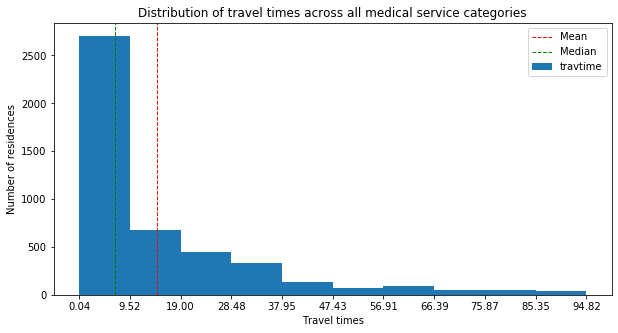

In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure() 

# histogram showing distribution of residences by traveltime for each medical service
count, bin_edges = np.histogram(resid_med_serv_df['travtime']) 

ax = resid_med_serv_df['travtime'].plot(kind='hist', xticks=bin_edges, figsize=(10, 5))

ax.set_title('Distribution of travel times across all medical service categories')
ax.set_xlabel('Travel times')
ax.set_ylabel('Number of residences')

ax.axvline(resid_med_serv_df['travtime'].mean(), linestyle='dashed', color='r', linewidth=1, label='Mean')
ax.axvline(resid_med_serv_df['travtime'].median(), linestyle='dashed', color='g', linewidth=1, label='Median')

ax.legend()

print('Average Travel Time = ', round(resid_med_serv_df['travtime'].mean(), 1), 'minutes')
print('Median Travel Time = ', round(resid_med_serv_df['travtime'].median(), 1), 'minutes')

We see that the distribution of travel times follow a right-skewed normal distribution with a median of 6.5 minutes.

<h3>3.3 Distribution of travel times by medical service category.</h3>

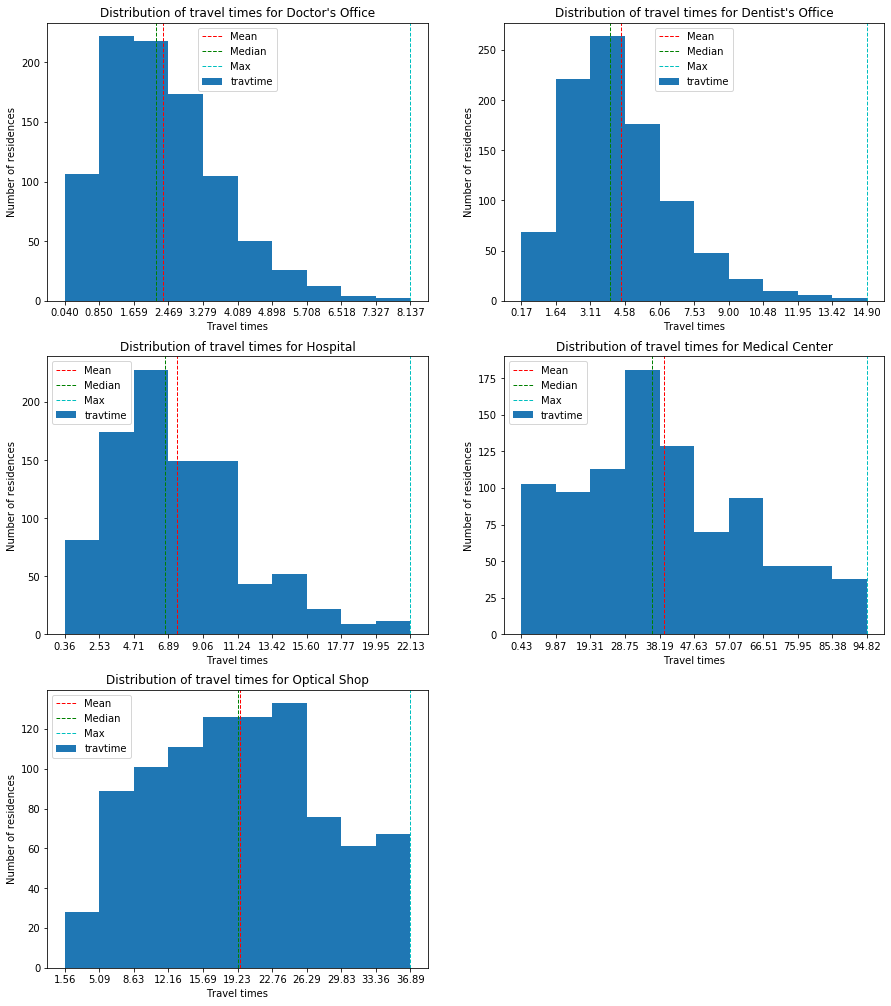

In [74]:
import math
fig = plt.figure(figsize = (15,15)) 
ax=[]

for i in range(len(med_cat.index)):
    ax.append(fig.add_subplot(math.ceil(len(med_cat.index)/2), 2, i+1))

j=0
for cat in med_cat['category']:
    count, bin_edges = np.histogram(resid_med_serv_df[resid_med_serv_df['category'] == cat]['travtime']) 
    resid_med_serv_df[resid_med_serv_df['category'] == cat]['travtime'].plot(kind='hist', xticks=bin_edges, ax=ax[j])
    ax[j].set_title('Distribution of travel times for ' + cat)
    ax[j].set_xlabel('Travel times')
    ax[j].set_ylabel('Number of residences')
    
    ax[j].axvline(resid_med_serv_df[resid_med_serv_df['category'] == cat]['travtime'].mean(), linestyle='dashed', color='r', linewidth=1, label='Mean')
    ax[j].axvline(resid_med_serv_df[resid_med_serv_df['category'] == cat]['travtime'].median(), linestyle='dashed', color='g', linewidth=1, label='Median')
    ax[j].axvline(resid_med_serv_df[resid_med_serv_df['category'] == cat]['travtime'].max(), linestyle='dashed', color='c', linewidth=1, label='Max')

    ax[j].legend()

    j = j+1

plt.subplots_adjust(top = 1)

<h4><b>Observations:<b></h4>
<ul>
    <li>The maximum travel times for Doctor Offices and Dentist Offices are below 15 minutes. Therefore all residences are within a 15 minutes walk from a doctor's office or a dentist's office.</li>
    <li>For hospitals we can see that the majority of residences are within 15 minutes, the number of records above 15 minutes is not high based on what we can see on the histogram. </li>
    <li>For optical shops and medical centers, the median is higher than 15 minutes, so at least 50% of residences are not within 15 minutes of these medical services.</li>
</ul>

In [75]:
# do this for each district

<h3>3.4 Ratio of residences meeting the 15 minutes target for all services.</h3>

First we create a dataframe containing a 15 Minutes Flag representing the overall 15 minutes readiness of a residence, by applying a boolean product on the 15 Min Flag of each medical service for a given residence.

In [76]:
# Create a temporary dataframe containing a 15 Minutes Flag representing the overall 15 minutes readiness of a residence, 
# by applying a boolean product on the 15 Min Flag of each medical service for a given residence. 
tmp_res_flag = resid_med_serv_df.groupby(['Residence ID'], as_index=False)['15minFlag'].prod()
print('First few records of this dataframe:')
tmp_res_flag.head()

First few records of this dataframe:


Residence ID  15minFlag
0  0083df4fba319de7342cf5a5d254ea15914f6f69      False
1  011afab78f920507093c1af1be4a8032441ad88c      False
2  012031053b36fcf6afe93ec9cecb57ca9b279a9e      False
3  012bcdda2bac6e3a109403fcc46fb87afd06e023      False
4  013261a0838f2b75abf4888307d18dfcc1a5be86      False

In [77]:
### Create a final Residences dataframe with this overall flag by joining residences_df with the temporary dataframe just created
final_res_df = residences_df.join(tmp_res_flag.set_index('Residence ID'), on='Residence ID')

# We drop the tmpkey column that we do not need anymore
final_res_df.drop(['tmpkey'], axis=1, inplace=True)

TravFlag_df = final_res_df.groupby(['District','15minFlag'], as_index=False).count()

print('We create a dataframe counting for each district the number of residences by 15 minutes status:')
TravFlag_df.head()

We create a dataframe counting for each district the number of residences by 15 minutes status:


District  15minFlag  Residence ID  Postal Code  Residence Lat  \
0        17      False           223          223            223   
1        18      False           427          427            427   
2        19      False           172          172            172   
3        19       True            96           96             96   

   Residence Long  
0             223  
1             427  
2             172  
3              96

In [78]:
print('Another useful dataframe created during this process, showing for each residence the value of the overall 15 minutes flag:')
final_res_df.head()

Another useful dataframe created during this process, showing for each residence the value of the overall 15 minutes flag:


Residence ID  Postal Code  Residence Lat  \
0  97ea2de86da630c8d747f2fff56fb98fa50ca080        75019      48.898624   
1  60adda8cbfaf3d675ff74e0df7f30634a32729a5        75018      48.896724   
2  e99900654a9dd5c8f284b727891dc3376254edfb        75019      48.875744   
3  e491fc803976f1fd7069c4e66e6d18e43616146c        75019      48.892673   
4  d48ddcb59d1c6756b54f6b4c1874dfe9bcf6334c        75017      48.885754   

   Residence Long  District  15minFlag  
0        2.379723        19      False  
1        2.358741        18      False  
2        2.399541        19      False  
3        2.385416        19      False  
4        2.289612        17      False

We can now visualize, for each district, a bar chart showing the distribution of residences by "15 minutes" status.

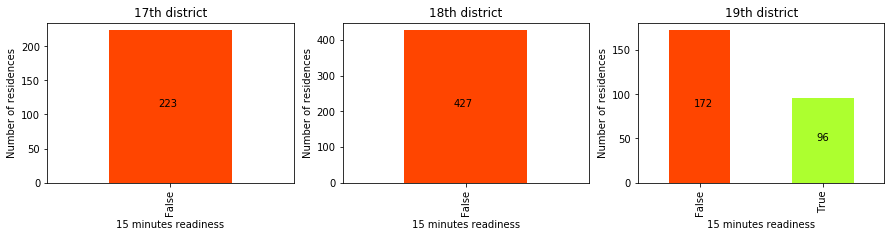

In [79]:
# bar charts showing distribution of overall 15minFlag distribution for each district
fig2 = plt.figure(figsize = (15,10)) 
ax2=[]

district_ct = len(TravFlag_df['District'].unique())

for i in range(district_ct):
    ax2.append(fig2.add_subplot(district_ct, 3, i+1))

j=0
for district in TravFlag_df['District'].unique():
    tmpdf = TravFlag_df[TravFlag_df['District'] == district][['District', '15minFlag', 'Residence ID']]
    tmpdf.set_index('15minFlag', drop=True, inplace=True)
    tmpdf['Residence ID'].plot(kind='bar', color=['orangered', 'greenyellow'], ax=ax2[j])
    ax2[j].set_title(str(district) + 'th district')
    ax2[j].set_xlabel('15 minutes readiness')
    ax2[j].set_ylabel('Number of residences')
    
    for p in ax2[j].patches:
        ax2[j].annotate(int(round(p.get_height())), (p.get_x() + 0.2, p.get_height()/2))
        
    j = j+1

        

<h4>Observations:</h4>
<ul>
    <li>None of the districts achieve 100% of residences meeting the overall 15 minutes objective.</li>
    <li>The 19th district is the only district that has some residences meeting the overall 15 minutes objective.</li>
</ul>

<h3>3.5 Ratio of residences meeting the 15 minutes target by medical service category in each district.</h3>

In [80]:
# add a district column to the resid_med_serv_df dataframe
resid_med_serv_df['District'] = resid_med_serv_df['Postal Code'] - 75000

# create a dataframe counting the number of residences by district, by medical category and by 15 minutes status
tmp1 = resid_med_serv_df.groupby(['District', 'category', '15minFlag'], as_index=False).count()
tmp1 = tmp1[['District', 'category', '15minFlag', 'Residence ID']]
tmp1.rename(columns = {'Residence ID': 'Res Count'}, inplace = True)

# create a dataframe counting the number of residences by district
residences_df['District'] = residences_df['Postal Code'] - 75000
res_total = residences_df.groupby(['District'], as_index=False)['Residence ID'].count()               
res_total.rename(columns = {'Residence ID': 'Res Total'}, inplace = True)

# merge the 2 dataframes 
# calculate a new column showing the ratio of residences either meeeting or not meeting the 15 minutes criteria
tmp2 = pd.merge(tmp1, res_total, on=['District'])
tmp2['Ratio'] = 100*(tmp2['Res Count'] / tmp2['Res Total'])

print('We create a dataframe providing for each district and each medical service category, the ratio of residences for each value of the 15 minutes boolean flag.')
print('First few records of this dataframe:')
tmp2.head()


We create a dataframe providing for each district and each medical service category, the ratio of residences for each value of the 15 minutes boolean flag.
First few records of this dataframe:


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


District          category  15minFlag  Res Count  Res Total       Ratio
0        17  Dentist's Office       True        223        223  100.000000
1        17   Doctor's Office       True        223        223  100.000000
2        17          Hospital      False         11        223    4.932735
3        17          Hospital       True        212        223   95.067265
4        17    Medical Center      False        223        223  100.000000

In [81]:
# prepare a datafame for easy bar chart representation, 
# by using a pivot to convert the two 15 min flag values into distinct columns 
resid_status_ratio = pd.pivot_table(tmp2, index=['District', 'category'], columns='15minFlag', values='Ratio', fill_value=0)
resid_status_ratio.reset_index(inplace=True)
resid_status_ratio.rename(columns = {False:'>15min', True:'<15min'}, inplace=True)

print('We now create a dataframe that will enable an easy bar chart representation. First few records of this dataframe:')
resid_status_ratio.head()

We now create a dataframe that will enable an easy bar chart representation. First few records of this dataframe:


15minFlag  District          category      >15min      <15min
0                17  Dentist's Office    0.000000  100.000000
1                17   Doctor's Office    0.000000  100.000000
2                17          Hospital    4.932735   95.067265
3                17    Medical Center  100.000000    0.000000
4                17      Optical Shop   60.089686   39.910314

We can now visualize, for each district and each medical service, a bar chart showing the distribution of residences by "15 minutes" status.

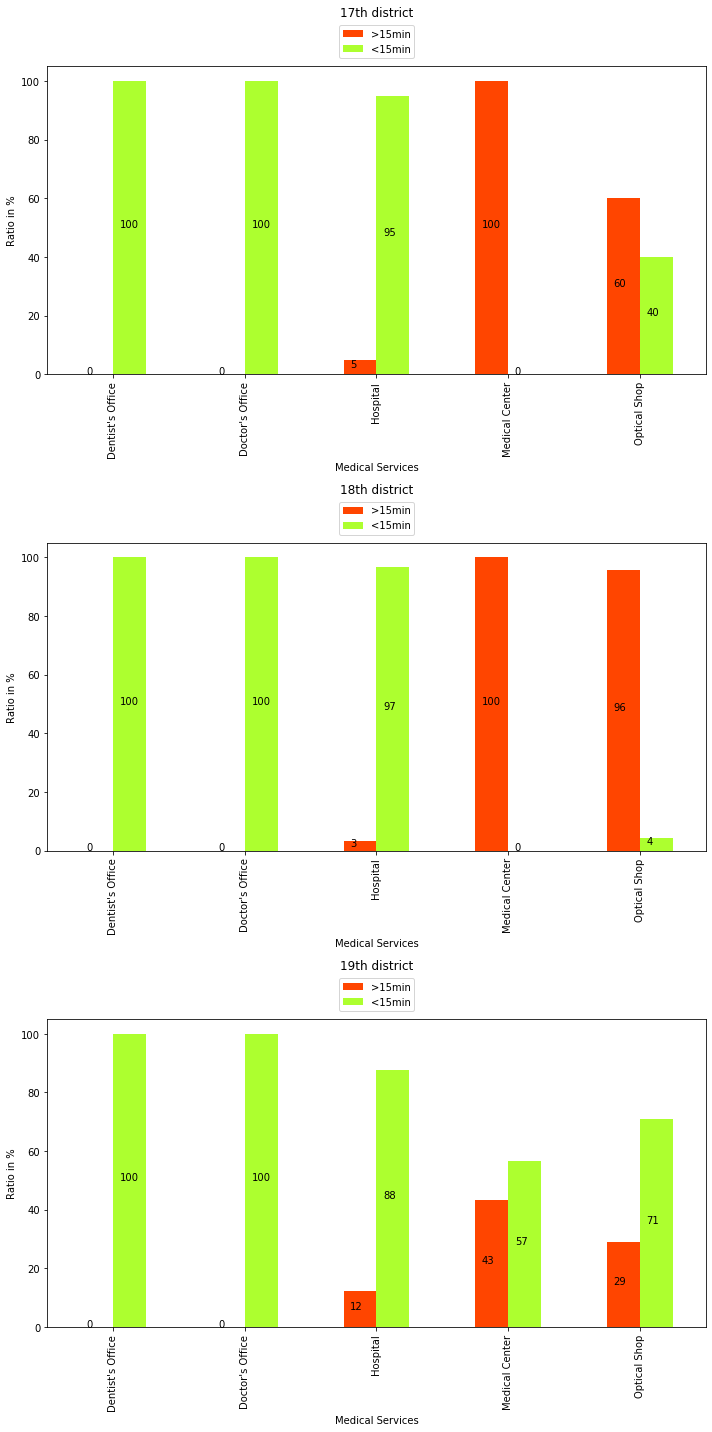

In [82]:
# bar charts showing distribution of 15minFlag distribution by medical service for each district
fig3 = plt.figure(figsize = (10,20)) 
ax3=[]

district_ct = len(resid_status_ratio['District'].unique())

for i in range(district_ct):
    ax3.append(fig3.add_subplot(district_ct, 1, i+1))

j=0
for district in resid_status_ratio['District'].unique():
    tmpdf = resid_status_ratio[resid_status_ratio['District'] == district][['category', '>15min', '<15min']]
    tmpdf.set_index('category', drop=True, inplace=True)
    tmpdf.plot(kind='bar', color=['orangered', 'greenyellow'], ax=ax3[j]).legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))
    
    ax3[j].set_title(str(district) + 'th district', pad=50)
    ax3[j].set_xlabel('Medical Services')
    ax3[j].set_ylabel('Ratio in %')
    
    for p in ax3[j].patches:
        ax3[j].annotate(int(round(p.get_height())), (p.get_x()+0.05, p.get_height()/2))
        
    j = j+1
    
plt.tight_layout()

<h4>Observations:</h4>
<ul>
    <li>In all 3 districts, all residences are within 15 minutes of a doctor's office and a dentist's office.</li>
    <li>Only the 17th district are all residences also within 15 minutes of a hospital.</li>
    <li>In the 18th and 19th districts, a large majority of residences are within 15 minutes of a hospital (97% and 88%).</li>
    <li>In the 19th district a majority of residences are within 15 minutes of a medical center and an optical shop (57% and 71%).</li>
    <li>In the 17th and 18th districts a minority of residences are within 15 minutes of a medical center and an optical shop, especially in the 18th where it is a really small fraction of residences (less than 10%).</li>
</ul>

<h3>3.6 Visualizations on a map</h3>

<h4>Overall 15 minutes readiness</h4>

In [83]:
# map of residences with pop up indications or color coding based on status for overall readiness and by medical services category

# Create a map of Paris using coordinates close to the center of the 18th district, which is located between the 17th and 19th. 
NorthParisLoc = [48.88677, 2.346256]
map_paris_15minflag = folium.Map(location=NorthParisLoc, zoom_start=13)

# set color scheme for the 15 minutes readiness flags
color_tbl = ['orangered', 'greenyellow']

# add markers to the map
for resID, lat, lon, district, flag in zip(final_res_df['Residence ID'], final_res_df['Residence Lat'], final_res_df['Residence Long'], final_res_df['District'], final_res_df['15minFlag']):
    label = folium.Popup('Residence ID:' + resID + ' / District:' + str(district) + ' / 15 Min Readiness: ' + str(flag), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=color_tbl[int(flag)],
        fill=True,
        fill_color=color_tbl[int(flag)],
        fill_opacity=1).add_to(map_paris_15minflag)

# add legend
print('Residences meeting the 15 minutes objective for all medical services are indicated in green on the map.')

map_paris_15minflag

Residences meeting the 15 minutes objective for all medical services are indicated in green on the map.


In [84]:
# map of residences with pop up indications or color coding based on status for overall readiness and by medical services category

# Create a map of Paris using coordinates close to the center of the 18th district, which is located between the 17th and 19th. 
NorthParisLoc = [48.88677, 2.346256]
map_paris_15minflag_2 = folium.Map(location=NorthParisLoc, zoom_start=13)

# set color scheme for the 15 minutes readiness flags
cat_num = len(resid_med_serv_df['category'].unique()) + 1
color_tbl = []
x = np.arange(cat_num)
y = [i + x + (i*x)**2 for i in range(cat_num)]
colors_array = cm.rainbow(np.linspace(0, 1, len(y)))
color_tbl = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for resID, lat, lon, district, flag in zip(final_res_df['Residence ID'], final_res_df['Residence Lat'], final_res_df['Residence Long'], final_res_df['District'], final_res_df['15minFlag']):
    tmp_label = ''
    detailed_flag = 0
    for index, row in resid_med_serv_df[resid_med_serv_df['Residence ID'] == resID].iterrows():
        tmp_label = tmp_label + row['category'] + ':' + str(row['15minFlag']) + ' | '
        detailed_flag = detailed_flag + int(row['15minFlag']) 
        
    label = folium.Popup('Residence ID:' + resID + ' / District:' + str(district) + ' / 15 Min Readiness by medical service: ' + tmp_label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius= 4,
        popup=label,
        #color=color_tbl[int(detailed_flag)],
        #color = '#' + str(detailed_flag*11) + 'EE' + str(detailed_flag*11),
        color = color_tbl[detailed_flag],
        fill=True,
        #fill_color=color_tbl[int(detailed_flag)],
        fill_color = color_tbl[detailed_flag],
        fill_opacity=1).add_to(map_paris_15minflag_2)

print('Click on a marker to see the 15 minutes status of each medical service associated to the residence.')
    
map_paris_15minflag_2

Click on a marker to see the 15 minutes status of each medical service associated to the residence.


<h2>4. RESIDENCES CLUSTERING</h2>

<h4>
Our goal now is to attempt to cluster residences to identify potential groupings of residences that share similar characteristics in relation to their "15 minutes" status for medical services. If these clusters are relevant, we might be able to determine specific actions for each cluster in order to address their "15 minutes" status.   
</h4>

<h3>Approach</h3>
<ol>
    <li>Perform a one hot encoding transformation in order to obtain a dataframe showing for each residence a boolean flag of the 15 minutes status for each medical service.</li>
    <li>Apply the clustering algorithm on the dataframe containing the one hot encoded values.</li>
    <li>Assign the cluster labels generated in the previous steps to our final_res_df dataframe created previously. This will provide us with a final residences dataframe in which each residence has a cluster label.</li>
    <li>Display the clustered residences on a map.</li>
    <li>Run some simple analysis on the cluster structure.</li>
    <li>Use the map and the analysis to identify some potential conclusions.</li>
    
</ol>

<h4>4.1 One hot encoding transformation</h4>

In [85]:
# Create a temporary dataframe listing each residence with each medical category and the 15 minutes flag.
# Include a new column appending the medical service and the 15 minutes flag value. 
#This is the new column on which we will apply the one hot encoding transformation.

resid_med_serv_df_prep = resid_med_serv_df[['Residence ID', 'category', '15minFlag']]
resid_med_serv_df_prep['category_flag'] = resid_med_serv_df_prep['category'] + '_' + resid_med_serv_df_prep['15minFlag'].astype(str)  

medserv_onehot = pd.get_dummies(resid_med_serv_df_prep['category_flag'], prefix="", prefix_sep="")
medserv_onehot['Residence ID'] = resid_med_serv_df['Residence ID']

fixed_columns = [medserv_onehot.columns[-1]] + list(medserv_onehot.columns[:-1])
medserv_onehot = medserv_onehot[fixed_columns]
medserv_onehot_final = pd.DataFrame()
medserv_onehot_final = medserv_onehot.groupby('Residence ID').sum().reset_index()

# We sort this dataframe on the Residence ID.
# This will help later when we match the clustering labels calculated for these residences to the final_res_df dataframe.
medserv_onehot_final.sort_values(by='Residence ID', ascending=True, inplace=True)

print('Dataframe resulting of one hot encoding process:')
medserv_onehot_final.head()

Dataframe resulting of one hot encoding process:


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Residence ID  Dentist's Office_True  \
0  0083df4fba319de7342cf5a5d254ea15914f6f69                      1   
1  011afab78f920507093c1af1be4a8032441ad88c                      1   
2  012031053b36fcf6afe93ec9cecb57ca9b279a9e                      1   
3  012bcdda2bac6e3a109403fcc46fb87afd06e023                      1   
4  013261a0838f2b75abf4888307d18dfcc1a5be86                      1   

   Doctor's Office_True  Hospital_False  Hospital_True  Medical Center_False  \
0                     1               0              1                     1   
1                     1               1              0                     1   
2                     1               0              1                     1   
3                     1               0              1                     1   
4                     1               0              1                     1   

   Medical Center_True  Optical Shop_False  Optical Shop_True  
0                    0                   1                  0  
1                    0                   1                  0  
2                    0                   1                  0  
3                    0                   1                  0  
4                    0                   1                  0

<h4>4.2 Clustering</h4>

In [86]:
# set number of clusters
kclusters = 5

res_med_clustering = medserv_onehot_final.drop('Residence ID', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(res_med_clustering)

# check cluster labels generated for each row in the dataframe
print("We take a look at the first 10 labels that have been assigned as a result of this clustering:")
kmeans.labels_[0:9] 

We take a look at the first 10 labels that have been assigned as a result of this clustering:


array([1, 4, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [87]:
#res_med_clustering.shape
print('Number of labels generated: ', len(kmeans.labels_))

Number of labels generated:  918


<h4>4.3 Assign the cluster labels to the residences dataframe</h4>

In [88]:
# First we sort final_res_df on the Residence ID to ensure that when we assign the 
# clustering labels they match the residence ID they were calculated for
final_res_df.sort_values(by='Residence ID', ascending=True, inplace=True)

final_res_df.insert(0, 'Cluster Labels', kmeans.labels_)
print('First 5 records of our updated dataframe:')
final_res_df.head()

First 5 records of our updated dataframe:


Cluster Labels                              Residence ID  Postal Code  \
249               1  0083df4fba319de7342cf5a5d254ea15914f6f69        75018   
133               4  011afab78f920507093c1af1be4a8032441ad88c        75018   
81                1  012031053b36fcf6afe93ec9cecb57ca9b279a9e        75018   
447               1  012bcdda2bac6e3a109403fcc46fb87afd06e023        75018   
497               1  013261a0838f2b75abf4888307d18dfcc1a5be86        75017   

     Residence Lat  Residence Long  District  15minFlag  
249      48.899979        2.336919        18      False  
133      48.892625        2.363521        18      False  
81       48.889486        2.355137        18      False  
447      48.888213        2.360603        18      False  
497      48.892504        2.327071        17      False

<h4>4.4 Visualize the residence clusters on a map</h4>

In [89]:
# map of residences with pop up indications or color coding for clusters

# Create a map of Paris
address = 'Paris, FRANCE'

NorthParisLoc = [48.88677, 2.346256]
map_paris_clusters = folium.Map(location=NorthParisLoc, zoom_start=13)

# set color scheme for the clusters
cluster_color_tbl = []
x = np.arange(kclusters)
y = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(y)))
cluster_color_tbl = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for resID, lat, lon, district, cluster in zip(final_res_df['Residence ID'], final_res_df['Residence Lat'], final_res_df['Residence Long'], final_res_df['District'], final_res_df['Cluster Labels']):
    label = folium.Popup('Residence ID:' + resID + ' / District:' + str(district) + ' / Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_color_tbl[int(cluster)],
        fill=True,
        fill_color=cluster_color_tbl[int(cluster)],
        fill_opacity=0.7).add_to(map_paris_clusters)

print('Click on a marker to see the cluster number associated to the residence.')
map_paris_clusters

Click on a marker to see the cluster number associated to the residence.


<h4>Observations:</h4>
<ul>
    <li>Overall, the clusters are easy to identify on the map, there is no random dispersion of cluster members across the 3 districts.</li>
    <li>Clusters 2 (green) and 3 (orange) cover fairly continuous distinct geographical areas.</li>
    <li>Other clusters are fairly easy to delineate on the map, even if they don't cover a continuous geographical area.</li>
    <li>By understanding if there is a specific characteristic that links residences within the same cluster we might be able to determine some specific strategies to address any gaps in their ability to meet the 15 minutes target.</li>
    <li>The fact that residences within a given cluster are in fairly well delineated areas and not dispersed all over the map should help implementing these strategies.</li>
</ul>

<h4>4.5 Clusters analysis</h4>

Now we check the clusters to determine some potential characteristics that can be used to label them with a meaningful descriptor.
<br>
To do this we are going to create a new dataframe:
<ul>
    <li>The first column will be the cluster label.</li>
    <li>The other columns will represent each medical service</li>
    <li>The records will contain for each cluster, the number of residences where the 15 minutes flag is TRUE for a given medical service</li>
</ul>

This dataframe will enable us to create a bar chart for each cluster, showing the number of residences meeting the 15 minutes criteria for each medical service.


In [90]:
# First, we add the labels to the dataframe listing all residences with their medical services boolean flag
res_med_clustering.insert(0, 'Cluster Labels', kmeans.labels_)


In [91]:
# We create a simplified dataframe with just the columns that we need
res_med_simple = pd.DataFrame()
res_med_simple = res_med_clustering.loc[:, res_med_clustering.columns.str.contains('Cluster Labels') | res_med_clustering.columns.str.contains('_True')]


In [92]:
# Now we group this dataframe by cluster and calculate the number of residences with a medical services 15 minutes flag = TRUE
res_med_labels = res_med_simple.groupby(['Cluster Labels'], as_index=False).sum()

# remove the suffix "true" from the column names
col_names = res_med_simple.columns.tolist()
new_col_names = []
for i,v in enumerate(col_names):
    if v[-5:] == '_True':
        res_med_labels.rename(columns={v: v[0:len(v)-5]}, inplace=True) 

print('This is the dataframe that we can now use to generate bar graphs for each cluster:')
res_med_labels.head()

This is the dataframe that we can now use to generate bar graphs for each cluster:


Cluster Labels  Dentist's Office  Doctor's Office  Hospital  \
0               0             201.0            201.0     188.0   
1               1             520.0            520.0     520.0   
2               2              96.0             96.0      96.0   
3               3              56.0             56.0      56.0   
4               4              45.0             45.0       0.0   

   Medical Center  Optical Shop  
0             0.0         201.0  
1             0.0           0.0  
2            96.0          96.0  
3            56.0           0.0  
4             0.0           0.0

In [93]:
# prepare a dataframe with the count of residences per cluster
res_count_label = pd.DataFrame()
res_count_label = final_res_df.groupby(['Cluster Labels'], as_index=False).count()
res_count_label = res_count_label[['Cluster Labels', 'Residence ID']]

print('Dataframe containing the number of residences per cluster:')
res_count_label.head()

Dataframe containing the number of residences per cluster:


Cluster Labels  Residence ID
0               0           201
1               1           520
2               2            96
3               3            56
4               4            45

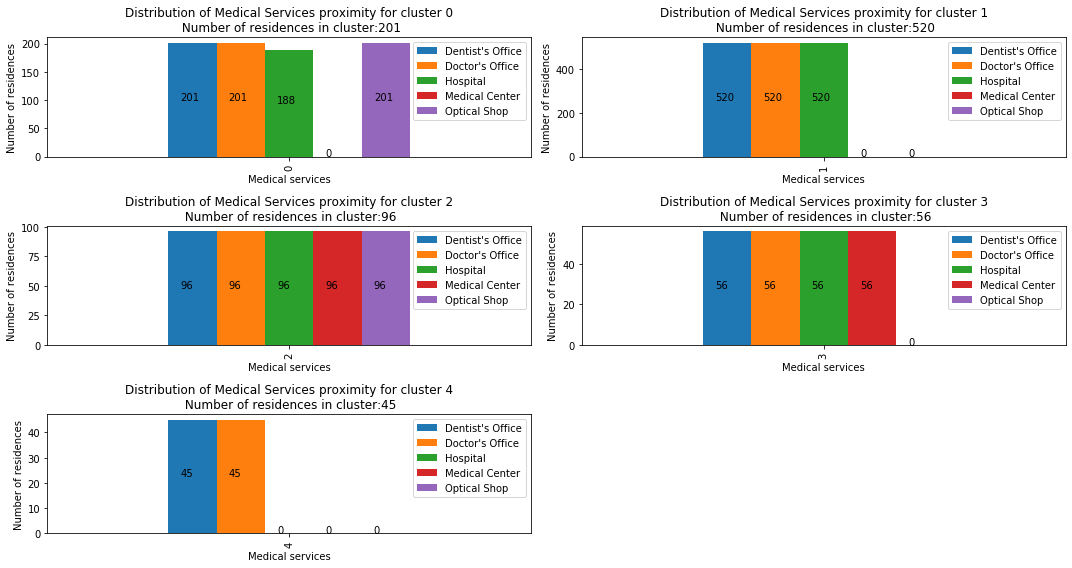

In [94]:
# Bar charts creation
fig3 = plt.figure(figsize = (15,8)) 
ax=[]

# Prepare a list of column names for the medical service categories. 
# This will be used to extract the data needed for the graph. 
cat_columns = [col for col in res_med_labels.columns if 'Cluster' not in col]

# Iterate through each cluster and generate a bar chart
i=0
for i in range(kclusters):
    ax.append(fig3.add_subplot((kclusters+1)/2, 2, i+1))
    #data = res_med_labels[res_med_labels['Cluster Labels'] == i].loc[:,res_med_labels.columns.str.contains('_True')]
    data = res_med_labels[res_med_labels['Cluster Labels'] == i].loc[:,cat_columns]
    data.plot(kind='bar', ax=ax[i])
    #res_med_labels[res_med_labels['Cluster Labels'] == i].loc[:,res_med_labels.columns.str.contains('_True')].plot(kind='bar', ax=ax[i])
    count_res_txt = str(int(res_count_label[res_count_label['Cluster Labels'] == i]['Residence ID']))
    ax[i].set_title('Distribution of Medical Services proximity for cluster ' + str(i) 
                    + '\n Number of residences in cluster:' 
                    + count_res_txt)
    ax[i].set_xlabel('Medical services')
    ax[i].set_ylabel('Number of residences')
   
    for p in ax[i].patches:
        ax[i].annotate(int(round(p.get_height())), (p.get_x()+0.025, p.get_height() / 2))
        
plt.tight_layout()

#plt.subplots_adjust(top = 2)

<h4>Observations:</h4>
<ul>
    <li>The bar charts above provide some useful information to understand what residences within each cluster have in common.</li>
    <li>Cluster 0 contains residences that are generally within 15 minutes walking distance of all medical services except medical centers. </li>
    <li>Cluster 1 contains residences that are generally within 15 minutes walking distance of all medical services except medical centers and optical shops.</li>
    <li>Cluster 2 contains residences that are generally within 15 minutes walking distance of all medical services except optical shops.</li>
    <li>Cluster 3 contains residences that are generally within 15 minutes walking distance of all medical services.</li>
    <li>Cluster 4 contains residences that are generally within 15 minutes walking distance of all medical services except hospitals, medical centers and optical shops.</li>
</ul>

<h4>These fairly clean patterns defining each cluster are helpful to determine what the gaps are for residences in these clusters (except cluster 3 where all residences are within 15 minutes distances of all medical services). This can help determine the right approach to address gaps in each cluster.</h4>

<h2>CONCLUSIONS</h2>
Our goal for this project was to address the following questions pertaining to easy access to medical services:
<ul>
<li>What is the overall current state of readiness of the city and the districts within it in respect to this "15 minutes" goal?</li> 
<li>Can we identify neighborhoods that share similar characteristics and group them together so that specific dedicated action plans can be defined to enable the "15 minutes" vision in these neighborhoods?</li>
</ul>

We have been able to answer both questions:
<ul>
<li>For the districts that we selected for this project, we have been able to determine the "15 minutes" readiness of these districts, at the residence level, by type of medical service. We obtained some numerical results and were also able to visualize on a map these results.</li> 
<li>We also identified common readiness characteristics shared by residences and even neighborhoods within the districts via a clustering exercise, supplemented by a map visualization of the clusters.</li>
</ul>